# Accuracy optimization of the DFT U-net

We demonstrate that a pure scalability can be reached for both the 1nn and 2nn system. However we can reach accuracies that can be considered low (rel err $=10^{-3}$). For this reason we wonder if we can force the CNN to outperform by increasing the learning capacity in both hidden channels, kernel size and convolutional blocks (without pooling).

We consider the 2nn case in the critical point and two datasets with $1.5 \cdot 10^3$ and $1.5 \cdot 10^4$ sample.



# The 2nn Case

#### Imports

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

## CNN prediction accuracy incresing the number of Hidden channels

#### Data

In [2]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock','2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 80]_hc_5_ks_2_ps_2_nconv_0_nblock','2nn_ising/h_5.44_15k_unet_periodic_augmentation_[80, 160]_hc_5_ks_2_ps_2_nconv_0_nblock']

data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*3

hc=[20,40,80]

ls=[128]*3

#### Accuracy analysis

In [3]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

REDENT(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 20, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
      (pooling 1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): Sequential(
      (conv2): Conv1d(20, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_2): GELU()
      (pooling 2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): ConvTranspose1d(40, 20, kernel_size=(6,), stride=(2,), padding=(2,))
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): ConvTranspose1d(20, 1, kernel_size=(6,), stride=(2,), padding=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=9101
R_square_test=0.9998987913131714 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock 

de=0.001974784

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


#### Plots

$R^2$

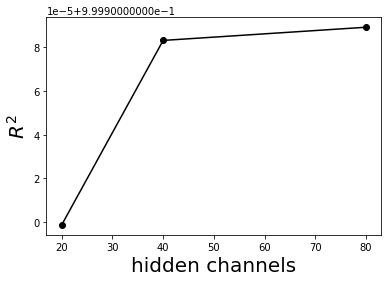

In [95]:
plt.plot([20,40,80],r,color='black',marker='o')
plt.xlabel('hidden channels',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

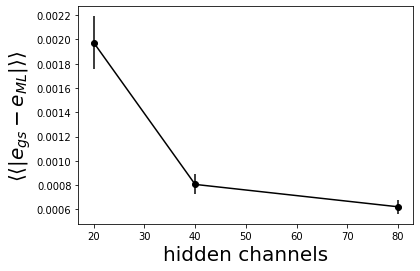

In [4]:
plt.errorbar([20,40,80],de,yerr=devde,color='black',marker='o')
plt.xlabel('hidden channels',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [5]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(hc)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]
    

#### Plots

()


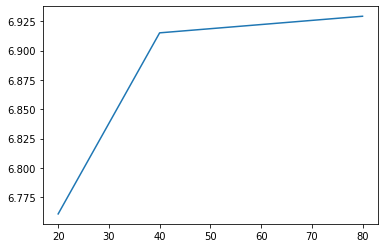

In [6]:
print(g_acc[0].shape)
plt.plot(hc,g_acc)
plt.show()

## Case b) U-Net without pooling incresing the kernel size

#### Data

In [7]:
ks=[1,3,5,7,9,11]

models_name=[f'2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_1_ks_{k}_ps_2_nconv_0_nblock' for k in ks]

data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*6



ls=[16]*6

#### Accuracy analysis

In [3]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

FileNotFoundError: [Errno 2] No such file or directory: 'model_rep/2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_1_ks_1_ps_2_nconv_0_nblock'

#### Plots

$R^2$

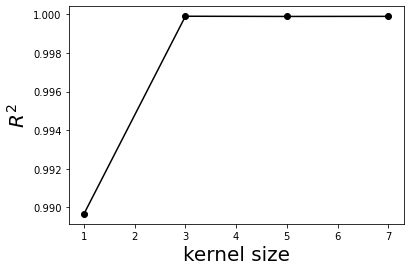

In [26]:
plt.plot(ks,r,color='black',marker='o')
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

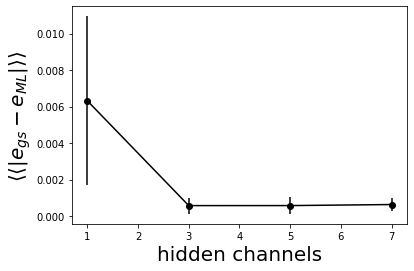

In [28]:
plt.errorbar(ks,de,yerr=devde,color='black',marker='o')
plt.xlabel('hidden channels',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [35]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(ks)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]
    

#### Plots

()


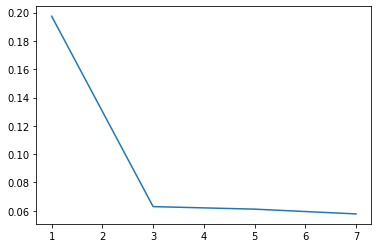

In [36]:
print(g_acc[0].shape)
plt.plot(ks,g_acc)
plt.show()

## Case c) U-Net without pooling size: a study for different kernel sizes

#### Data

In [5]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_1_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_3_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_7_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_9_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_11_ks_1_ps_2_nconv_0_nblock']


ks=[1,3,5,7,9,11]

ls=[16]*len( ks)


data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*len(ks)

#### Losses analysis

In [ ]:
for i,model_name in enumerate(models_name):
    plt.figure(figsize=(10,10))
    l_train=torch.load('losses_dft_pytorch/'+model_name+'_loss_train')
    l_valid=torch.load('losses_dft_pytorch/'+model_name+'_loss_valid')

    
    plt.plot(l_train,color='black',label='train')
    plt.plot(l_valid,color='red',linestyle='--',label='valid')
    plt.title(f'kernel_size={ks[i]}',fontsize=20)
    plt.xlabel('epochs',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.legend(fontsize=20)
    plt.loglog()
    plt.show()

#### Accuracy

In [5]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(1,), stride=(1,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
  (loss_dft): MSELoss()
)
# parameters=3401
R_square_test=0.9303698539733887 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_1_ks_1_ps_2_nconv_0_nblock 

de=0.01704405142089355 std(de)=0.011814007805344107
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(3,), stride=(1,

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


$R^2$

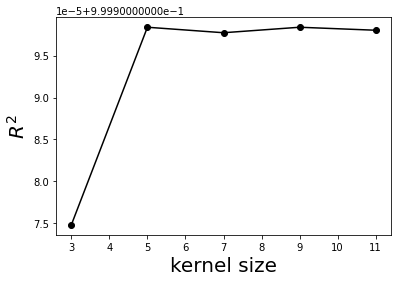

In [6]:
plt.plot(ks[1:],r[1:],color='black',marker='o')

plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

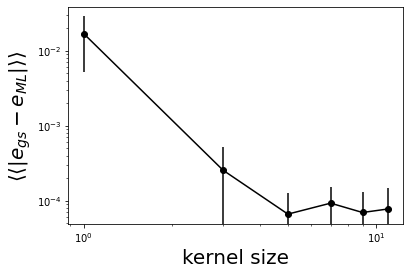

In [7]:
plt.errorbar(ks,de,yerr=devde,color='black',marker='o')
plt.loglog()
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Accuracy

In [10]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(ks)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]

#### Plot

()


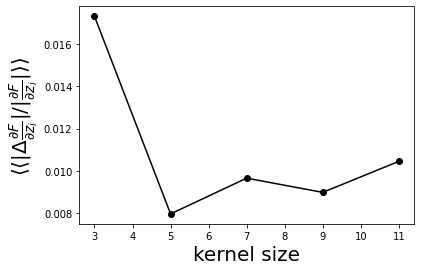

In [11]:
print(g_acc[0].shape)
plt.plot(ks[1:],g_acc[1:],color='black',marker='o')
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.show()

## Case b) U-Net without pooling incresing the number of convolutional blocks

#### Imports

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

#### Data

In [3]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
            '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40]_hc_5_ks_1_ps_3_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40, 40]_hc_5_ks_1_ps_5_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_7_nconv_0_nblock',
             ]


blocks=np.arange(7)

ls=[16]*len( blocks)


data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*len(blocks)

#### Loss Analysis

In [ ]:
for i,model_name in enumerate(models_name):
    plt.figure(figsize=(10,10))
    l_train=torch.load('losses_dft_pytorch/'+model_name+'_loss_train')
    l_valid=torch.load('losses_dft_pytorch/'+model_name+'_loss_valid')

    
    plt.plot(l_train,color='black',label='train')
    plt.plot(l_valid,color='red',linestyle='--',label='valid')
    plt.title(f'blocks={blocks[i+1]}',fontsize=20)
    plt.xlabel('epochs',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

#### Accuracy

In [5]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
  (loss_dft): MSELoss()
)
# parameters=16521
R_square_test=0.9999983906745911 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock 

de=0.00024646942579018157 std(de)=0.00028422869872026923
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequent

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


$R^2$

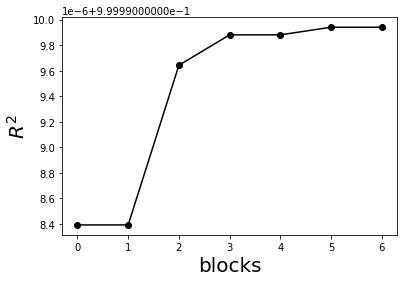

In [15]:
plt.plot(blocks,r,color='black',marker='o')

plt.xlabel('blocks',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

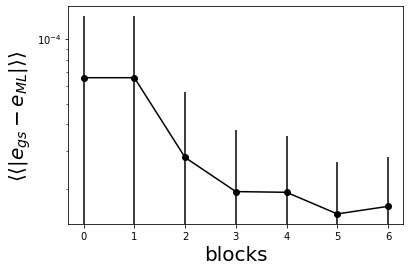

In [16]:
plt.errorbar(blocks,de,yerr=devde,color='black',marker='o')
plt.semilogy()
plt.xlabel('blocks',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Accuracy

In [17]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(blocks)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]

#### Plot

()


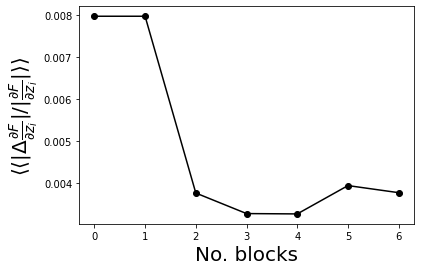

In [18]:
print(g_acc[0].shape)
plt.plot(blocks,g_acc,color='black',marker='o')
plt.xlabel('No. blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.show()

## Scalability Performance for different Kernel Size

#### Data

In [2]:
ls=[16,32,48,64,80,96,128]
#ls=[16,24,32,48,64]
data_path=[f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{l}_l_5.44_h_100_n.npz' for l in ls]

ks=[1,3,5,7,9,11]

models_name=[]
for k in ks:
    models_name.append(f'2nn_ising/h_5.44_15k_cnn_[40, 40, 40, 40]_hc_{k}_ks_1_ps_4_nconv_0_nblock')


#### Accuracy

In [3]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)    

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 1, kernel_size=(1,), stride=(1,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=3401
R_square_test=0.9235355257987976 for 2nn_ising/h_5.44_15k_cnn_[40, 40, 40, 40]_hc_1_ks_1_ps_4_nconv_0_nblock 

de=0.051493200351603034 std(de)=0.0036038737340418946
Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Seque

$R^2$

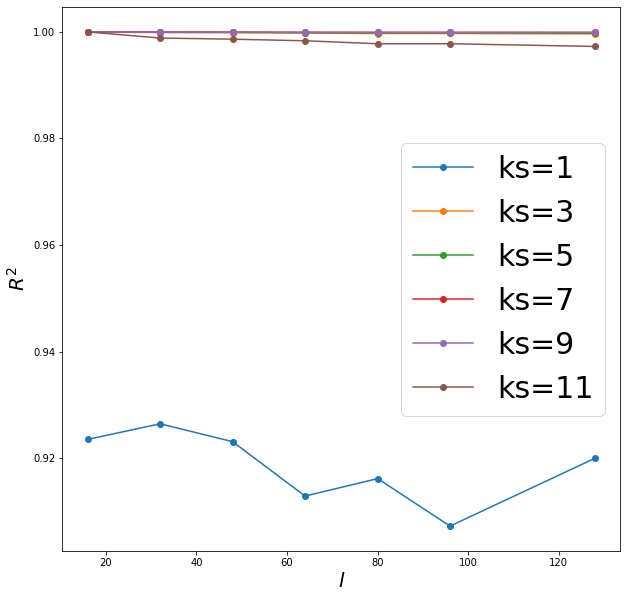

In [4]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'ks={ks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

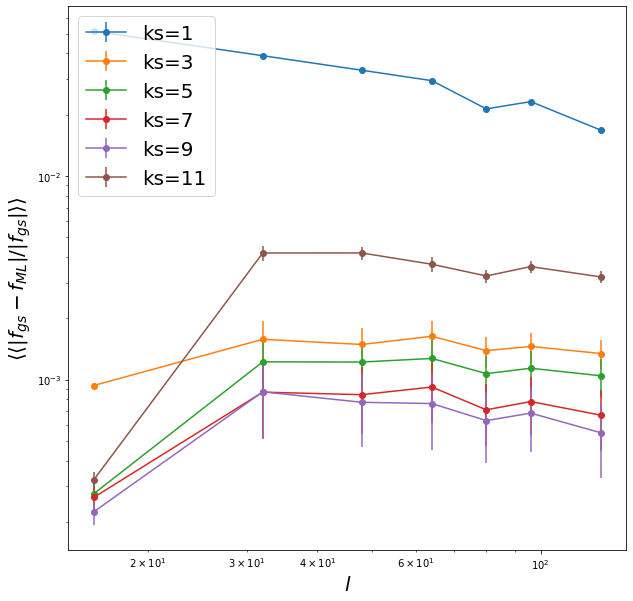

In [5]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'ks={ks[i]}')
plt.legend(fontsize=20)
plt.loglog()
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [6]:
ndata=1000
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

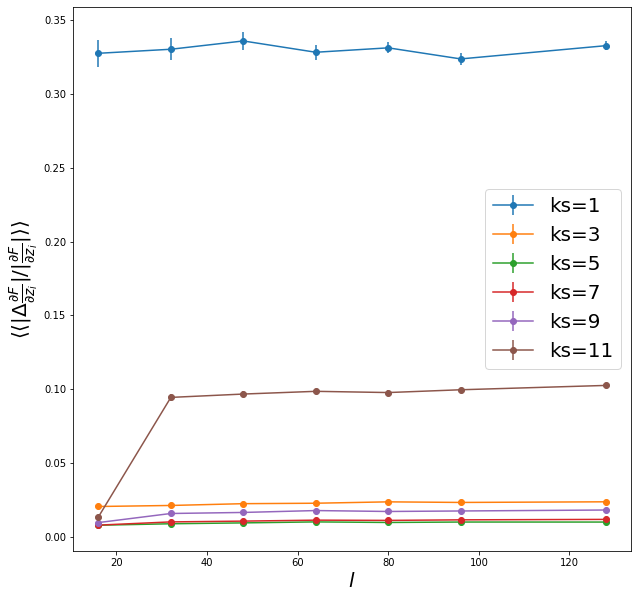

In [7]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'ks={ks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Gradient Descent Accuracy

#### Imports

In [16]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [17]:
ks=[1,3,5,7,9,11]
n_sample=len(ks)
h_max=[5.44]*n_sample
ls=[128]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_2_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample) ]

early_stopping=False
variational_lr=False
loglr=1

min_density=[]
gs_density=[]
min_energy=[]
gs_energy=[]
hs=[]

for i in range(n_sample):
    hs.append(np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]])
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)
    
            #if min_eng_t.shape[0]==min_eng.shape[-1]:
    min_energy.append(min_eng_t)
    gs_energy.append(gs_eng_t)
    min_density.append(min_n_t)
    gs_density.append(gs_n_t)
    
min_energy=np.asarray(min_energy)
gs_energy=np.asarray(gs_energy)
min_density=np.asarray(min_density)
gs_density=np.asarray(gs_density)    

#### Accuracy for different ks

Magnetization

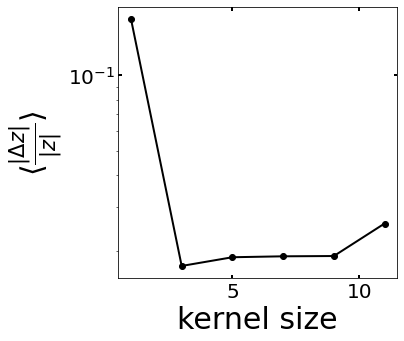

In [18]:

dz=(np.average(np.abs(gs_density-min_density),axis=-1))/np.average(np.abs(gs_density),axis=-1)

fig=plt.figure(figsize=(5,5))
plt.plot(ks,np.average(dz,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'kernel size',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta z|}{|z|} \rangle$',fontsize=30)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.semilogy()
plt.show()  

Energy

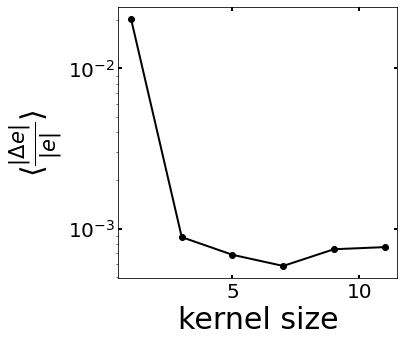

In [16]:
de=np.abs(gs_energy-min_energy)/np.abs(gs_energy)

fig=plt.figure(figsize=(5,5))
plt.plot(ks,np.average(de,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'kernel size',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta e|}{|e|} \rangle$',fontsize=30)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.semilogy()
plt.show() 

## Scalability analysis at different Depth of the Neural Network

#### Imports

In [9]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

#### Data

In [10]:

models_name=[]
hc=''
for i in range(6):
    models_name.append('2nn_ising/h_5.44_15k_cnn_[40, 40'+hc+f']_hc_5_ks_1_ps_{i+2}_nconv_0_nblock')
    hc=hc+', 40'
        


blocks=[2,3,4,5,6,7]
ls=[16,32,48,64,80,96,112,128]
#ls=[16,24,32,48,64]

data_path=[f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{l}_l_5.44_h_100_n.npz' for l in ls]

#### Accuracy

In [11]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)  

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=441
R_square_test=0.9997465014457703 for 2nn_ising/h_5.44_15k_cnn_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock 

de=0.0031323348925267154 std(de)=0.00034706079171545405
Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=441
R_square_test=0.9995783567428589 for 2nn_ising/h_5.44_15k_cnn_[40, 40

$R^2$

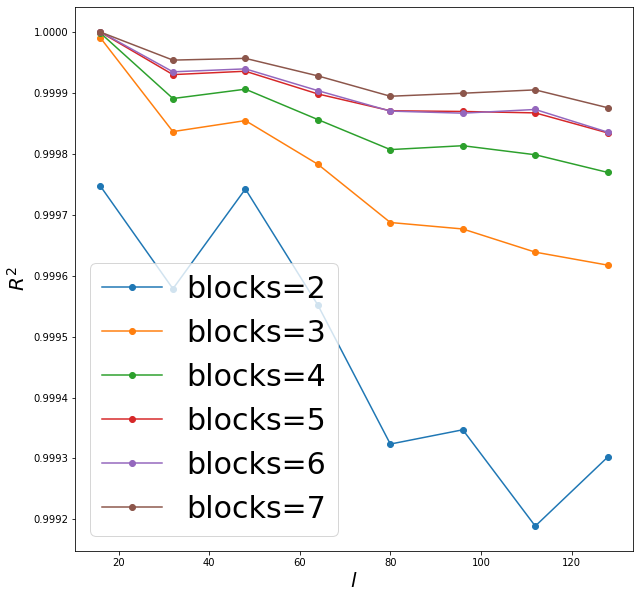

In [12]:
plt.figure(figsize=(10,10))

for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'blocks={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

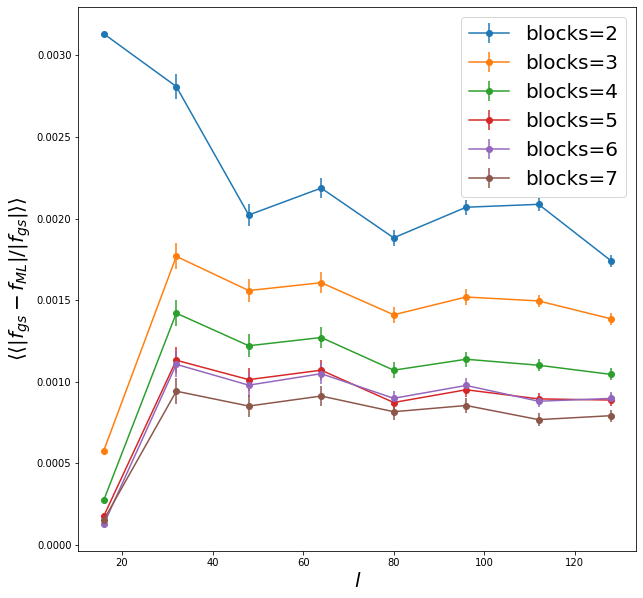

In [13]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'blocks={blocks[i]}')
plt.legend(fontsize=20)
#plt.plot(0.001*np.arange(len(ls))**(0.5))
#plt.loglog()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Descent Accuracy

In [22]:
ndata=100
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

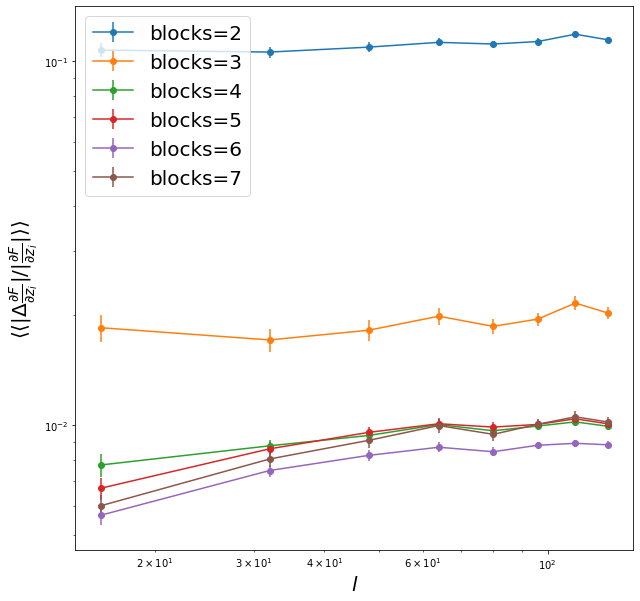

In [23]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'blocks={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.legend(fontsize=20)
plt.show()

### Gradient Descent Accuracy

#### Imports

In [24]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [28]:
blocks=[2,3,4,5,7]

n_sample=5
h_max=[5.44]*n_sample
ls=[16]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_2_layers_40_hc_5_ks_1_ps',
              f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_3_layers_40_hc_5_ks_1_ps',
              f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_4_layers_40_hc_5_ks_1_ps',
              f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_5_layers_40_hc_5_ks_1_ps',
              f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_6_layers_40_hc_5_ks_1_ps',
              f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_7_layers_40_hc_5_ks_1_ps' ]

early_stopping=False
variational_lr=False
loglr=1

min_density=[]
gs_density=[]
min_energy=[]
gs_energy=[]
hs=[]

for i in range(n_sample):
    hs.append(np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]])
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)
    
            #if min_eng_t.shape[0]==min_eng.shape[-1]:
    min_energy.append(min_eng_t)
    gs_energy.append(gs_eng_t)
    min_density.append(min_n_t)
    gs_density.append(gs_n_t)
    
min_energy=np.asarray(min_energy)
gs_energy=np.asarray(gs_energy)
min_density=np.asarray(min_density)
gs_density=np.asarray(gs_density)    

#### Accuracy for different dept 

Magnetization

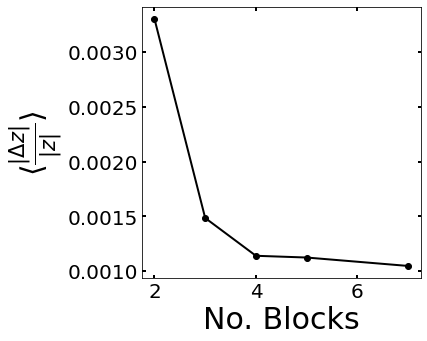

In [27]:

dz=(np.average(np.abs(gs_density-min_density),axis=-1))/np.average(np.abs(gs_density),axis=-1)

fig=plt.figure(figsize=(5,5))
plt.plot(blocks,np.average(dz,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'No. Blocks',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta z|}{|z|} \rangle$',fontsize=30)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.show()  

Energy

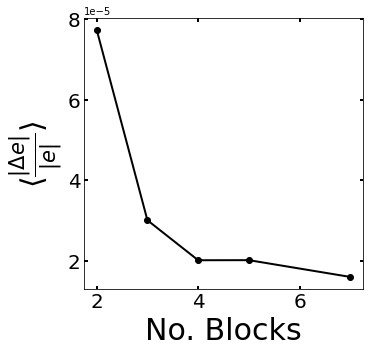

In [33]:
de=np.abs(gs_energy-min_energy)/np.abs(gs_energy)

fig=plt.figure(figsize=(5,5))
plt.plot(blocks,np.average(de,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'No. Blocks',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta e|}{|e|} \rangle$',fontsize=30)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.show() 

## Hidden channel case

#### Data

In [34]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
            '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[80, 80]_hc_5_ks_1_ps_2_nconv_0_nblock',
            '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[120, 120]_hc_5_ks_1_ps_2_nconv_0_nblock',
             ]
hc=[40,80,120]
ls=[16,24,32,64,96,108,128,136]
data_path=[f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_5.44_h_100_n.npz' for l in ls]

#### Accuracy

In [35]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde) 

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
  (loss_dft): MSELoss()
)
# parameters=16521
R_square_test=0.9999983906745911 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock 

de=0.00024646942579018157 std(de)=2.8422869872026925e-05
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequent

$R^2$

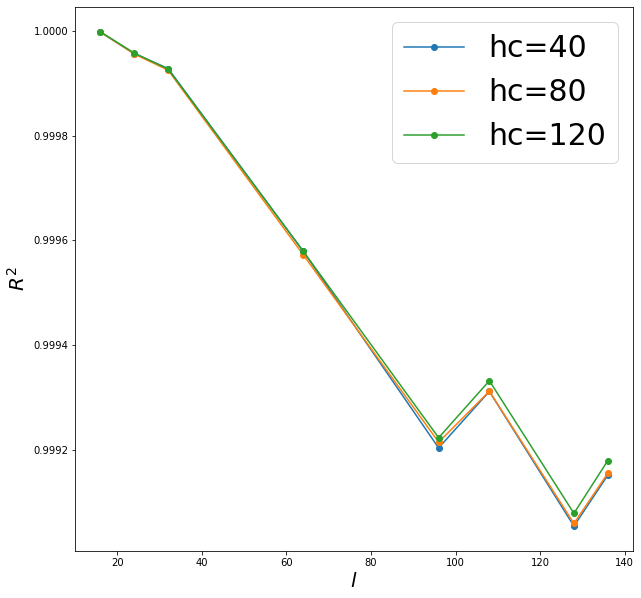

In [58]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'hc={hc[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

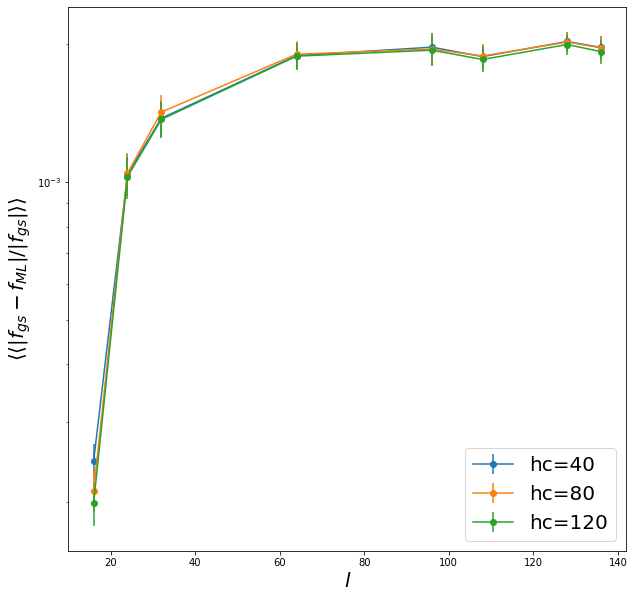

In [36]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'hc={hc[i]}')
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Descent Analysis

In [37]:
ndata=1000
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

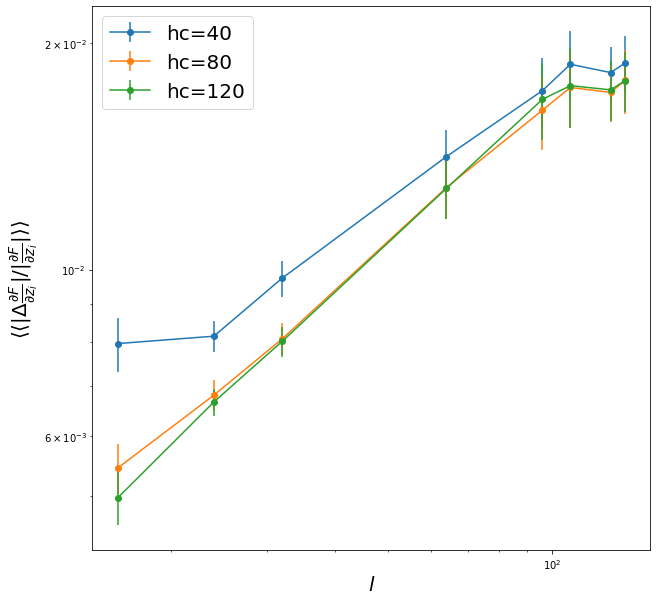

In [39]:
plt.figure(figsize=(10,10))
for i in range(0,len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'hc={hc[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.legend(fontsize=20)
plt.show()

## Analysis for different sizes of the Dataset

#### Imports

In [7]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

##### Data

In [2]:
n_dataset=['5k','10k','15k','30k','150k']
models_name=['2nn_ising/h_5.44_'+n_data+'_cnn_[40, 40, 40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_8_nconv_0_nblock' for n_data in n_dataset]
ls=[16,32,48,64,96,128]
data_path=[f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{l}_l_5.44_h_100_n.npz' for l in ls]

#### Accuracy

In [3]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde) 

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 4): GELU()
    )
    (4): Sequential(
      (conv5): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 5): GELU()
    )
    (5): Sequential(
      (conv6): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 6): GELU()
    )
    (6): Sequential(
      (conv7)

$R^2$

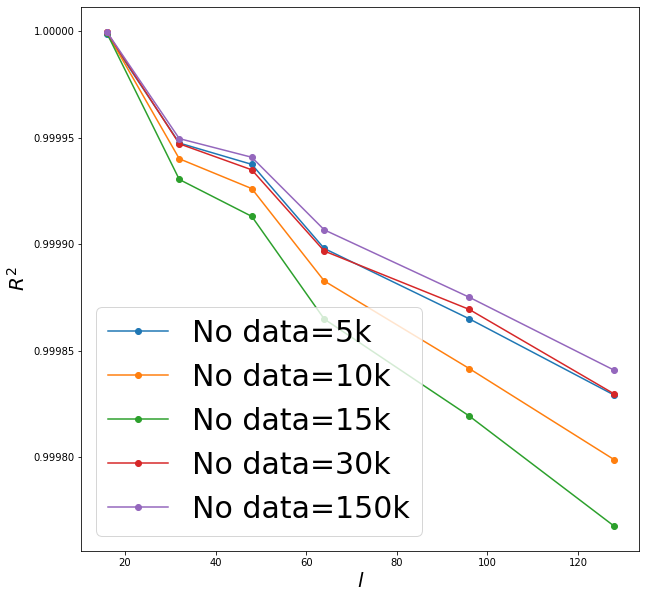

In [5]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'No data={n_dataset[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

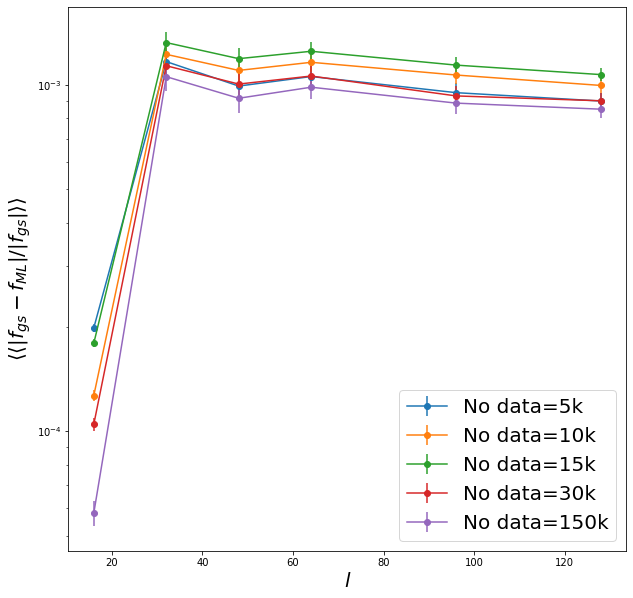

In [4]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'No data={n_dataset[i]}')
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Accuracy

In [7]:
ndata=1000
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

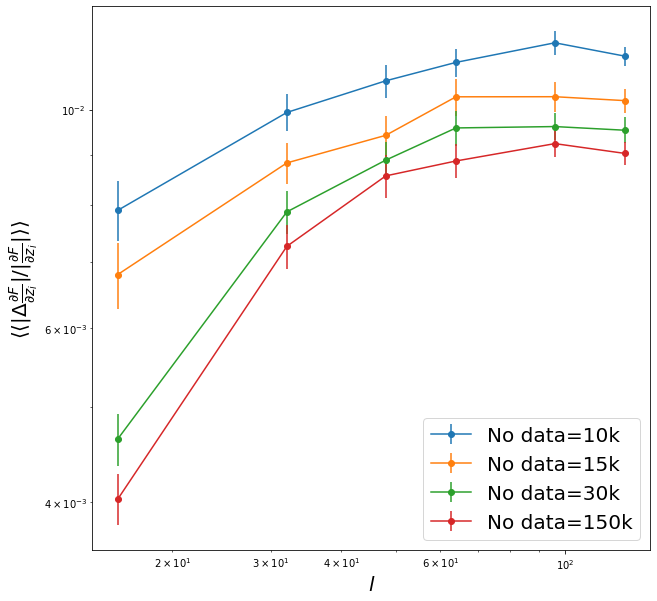

In [8]:
plt.figure(figsize=(10,10))
for i in range(1,len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'No data={n_dataset[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.legend(fontsize=20)
plt.show()

In [36]:
n_dataset=['5k','10k','15k','30k','150k']
n_sample=len(n_dataset)
h_max=[5.44]*n_sample
ls=[128]*n_sample
ks=[5]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[0]}_{n_dataset[i]}_augmentation_2nn_model_unet_{ls[0]}_size_4_layers_40_hc_{ks[0]}_ks_1_ps' for i in range(n_sample) ]

early_stopping=False
variational_lr=False
loglr=1

min_density=[]
gs_density=[]
min_energy=[]
gs_energy=[]
hs=[]

for i in range(n_sample):
    hs.append(np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]])
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)
    
            #if min_eng_t.shape[0]==min_eng.shape[-1]:
    min_energy.append(min_eng_t)
    gs_energy.append(gs_eng_t)
    min_density.append(min_n_t)
    gs_density.append(gs_n_t)
    
min_energy=np.asarray(min_energy)
gs_energy=np.asarray(gs_energy)
min_density=np.asarray(min_density)
gs_density=np.asarray(gs_density)    

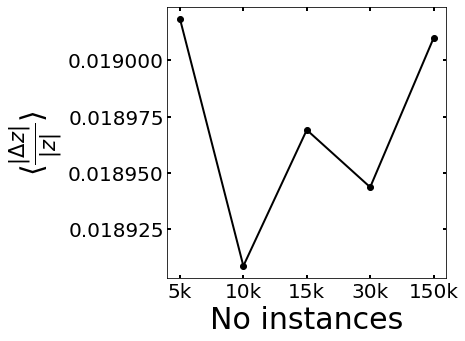

In [60]:

dz=(np.average(np.abs(gs_density-min_density),axis=-1))/np.average(np.abs(gs_density),axis=-1)

fig=plt.figure(figsize=(5,5))
plt.plot(np.average(dz,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'No instances',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta z|}{|z|} \rangle$',fontsize=30)
plt.xticks(np.arange(len(n_dataset)),n_dataset)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.show()  

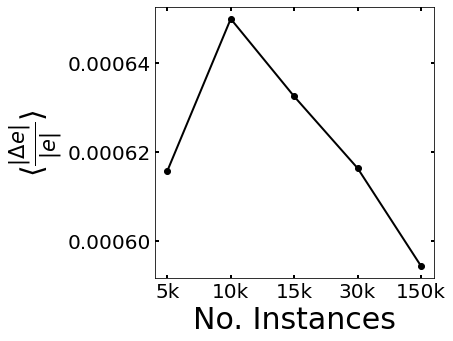

In [58]:
de=np.abs(gs_energy-min_energy)/np.abs(gs_energy)

fig=plt.figure(figsize=(5,5))
plt.plot(np.average(de,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'No. Instances',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta e|}{|e|} \rangle$',fontsize=30)
plt.xticks(np.arange(len(n_dataset)),n_dataset)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.show() 

## Study of the U-net with a Scalable training

#### Imports

In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

#### Data

In [12]:
model=torch.load('model_rep/2nn_ising/h_5.44_15k_scalable_training_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',map_location='cpu')
model.eval()


ls=[16,24,32,64,96,108,128,136]
data_path=[f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_5.44_h_100_n.npz' for l in ls]
models_name=['2nn_ising/h_5.44_15k_scalable_training_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock']


In [13]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde) 

REDENTScalableTraining(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_4): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (a

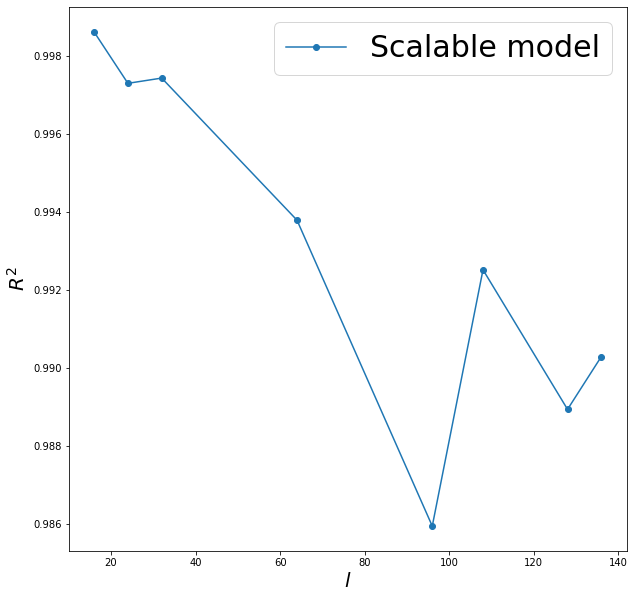

In [15]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'Scalable model')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

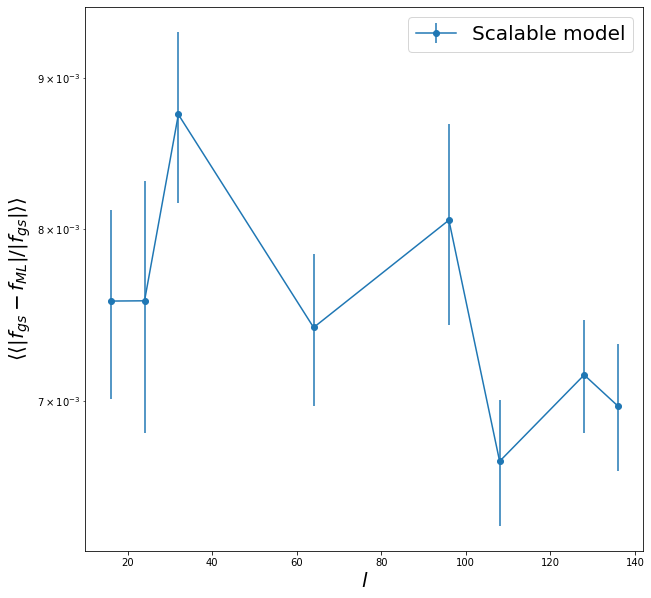

In [16]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'Scalable model')
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

## Prediction accuracy for different size training dataset

#### Imports

In [8]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

#### Data

In [9]:

models_name=[]
hc=''
for l in [8,12,18,20]:
    models_name.append(f'2nn_ising/h_5.44_15k_l_{l}_cnn_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock')
        


blocks=[8,12,18,20]
ls=np.arange(8,65)
#ls=[16,24,32,48,64]

data_path=[f'data/dataset_2nn/test_dataset_021222/test_periodic_{l}_l_5.44_h_100_n.npz' for l in ls]

#### Accuracy

In [10]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)  

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=16521
R_square_test=0.9999993443489075 for 2nn_ising/h_5.44_15k_l_8_cnn_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock 

de=0.00021114787274936512 std(de)=2.3076072978547705e-05
Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=

$R^2$

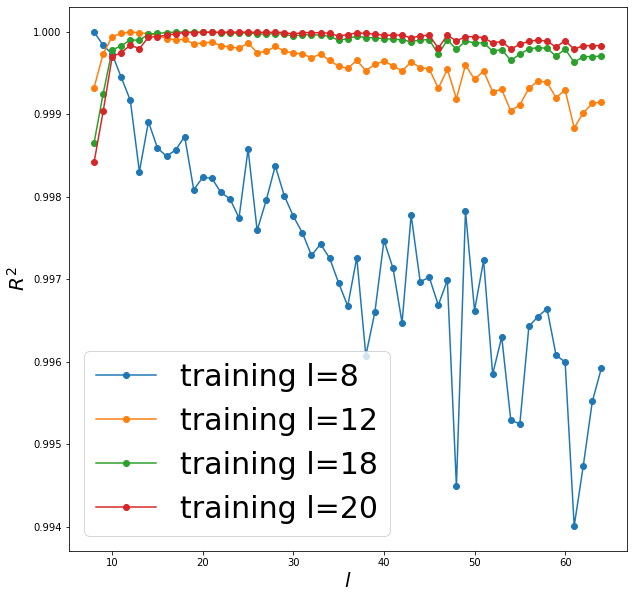

In [4]:
plt.figure(figsize=(10,10))

for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'training l={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

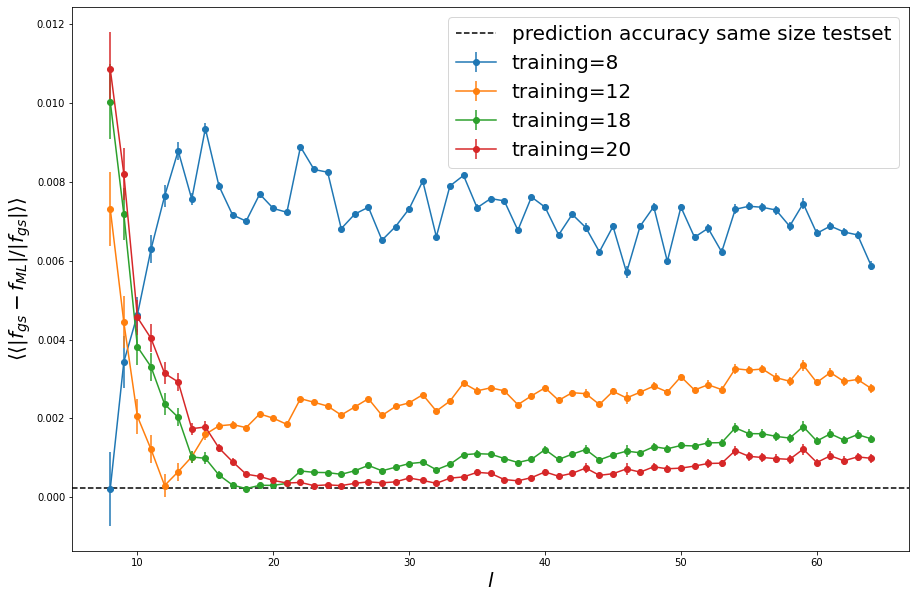

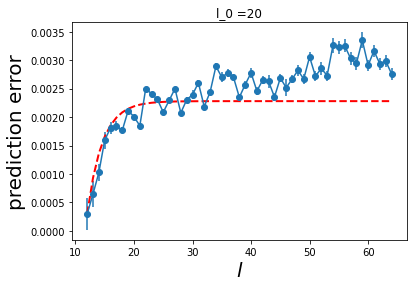

In [21]:
plt.figure(figsize=(15,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'training={blocks[i]}')

#plt.plot(0.001*np.arange(len(ls))**(0.5))
#plt.loglog()
plt.axhline(y=0.00023,color='black',linestyle='--',label='prediction accuracy same size testset')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

l_0=12
chi=2.6
size=64
err_ml=3*10**-4
# simulator
x=np.arange(65)
err_l=0.2*np.exp(-1*l_0/chi)*(1-np.exp(-1*np.abs(x-l_0)/chi))
plt.errorbar(ls[4:],des[1][4:],yerr=devde[4:],marker='o',label=f'ks=')
plt.plot(ls[4:],err_l[l_0:]+err_ml,color='red',linestyle='--',linewidth=2)
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel('prediction error',fontsize=20)
plt.title('l_0 =20')

plt.show()

#### Gradient Descent Accuracy

In [6]:
ndata=100
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

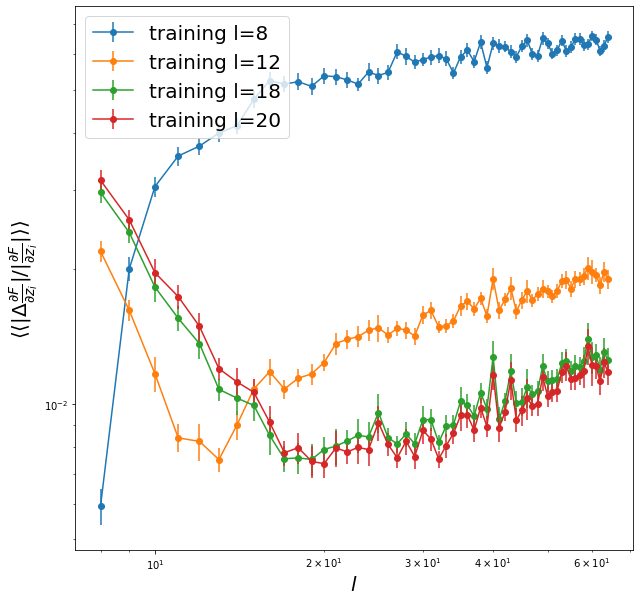

In [7]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'training l={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.legend(fontsize=20)
plt.show()

# The 1nn Case

#### Imports

In [4]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

## Scalability Performance for different Kernel Size

#### Data

In [5]:
ls=np.arange(16,33)
#ls=[16,24,32,48,64]
data_path=[f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{l}_l_2.7_h_200_n.npz' for l in ls]

ks=[1,3,5,7,9,11]

models_name=[]
for k in ks:
    models_name.append(f'1nn_ising/h_2.7_15k_cnn_[40, 40, 40, 40]_hc_{k}_ks_1_ps_4_nconv_0_nblock')


#### Accuracy

In [7]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)    

Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 1, kernel_size=(1,), stride=(1,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=3401
R_square_test=0.9734501242637634 for 1nn_ising/h_2.7_15k_cnn_[40, 40, 40, 40]_hc_1_ks_1_ps_4_nconv_0_nblock 

de=0.027163474737198802 std(de)=0.001563903798889374
Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequent

$R^2$

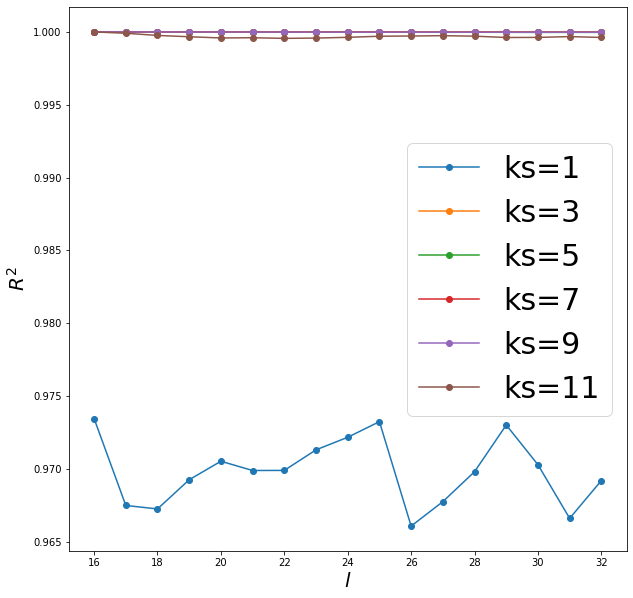

In [14]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'ks={ks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

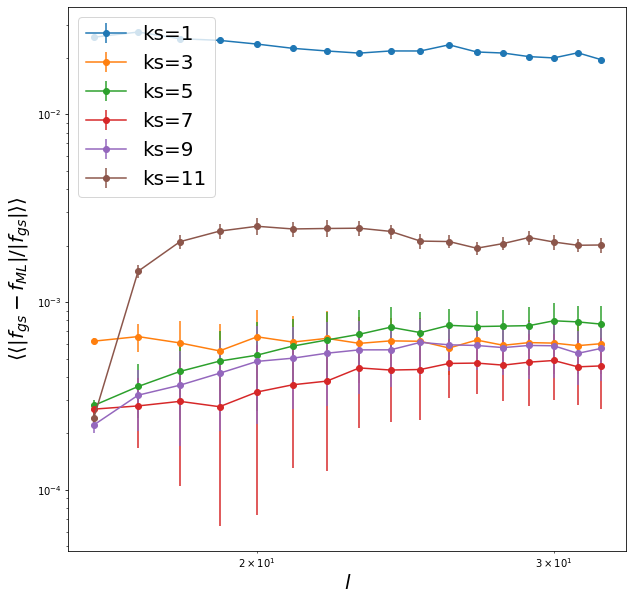

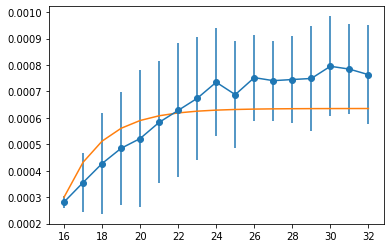

In [25]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'ks={ks[i]}')
plt.legend(fontsize=20)
plt.loglog()
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()



#### Gradient Analysis

In [16]:
ndata=1000
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

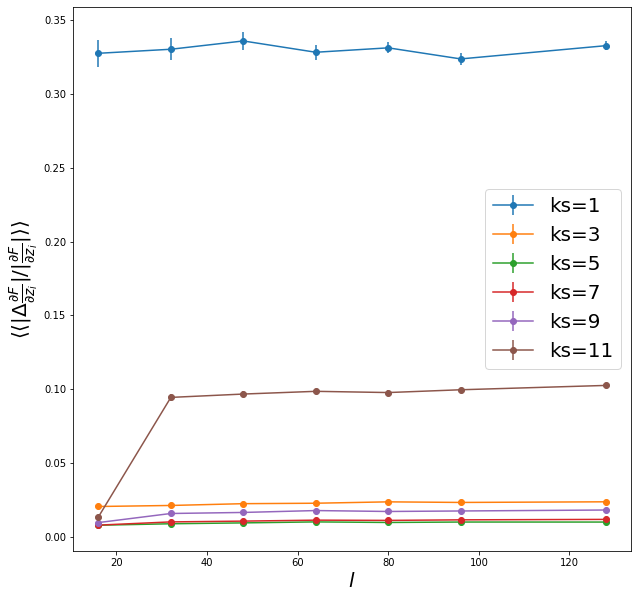

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'ks={ks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Gradient Descent Accuracy

#### Imports

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [ ]:
ks=[1,3,5,7,9,11]
n_sample=len(ks)
h_max=[5.44]*n_sample
ls=[128]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[0]}_15k_augmentation_2nn_model_unet_{ls[0]}_size_2_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample) ]

early_stopping=False
variational_lr=False
loglr=1

min_density=[]
gs_density=[]
min_energy=[]
gs_energy=[]
hs=[]

for i in range(n_sample):
    hs.append(np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]])
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)
    
            #if min_eng_t.shape[0]==min_eng.shape[-1]:
    min_energy.append(min_eng_t)
    gs_energy.append(gs_eng_t)
    min_density.append(min_n_t)
    gs_density.append(gs_n_t)
    
min_energy=np.asarray(min_energy)
gs_energy=np.asarray(gs_energy)
min_density=np.asarray(min_density)
gs_density=np.asarray(gs_density)    

#### Accuracy for different ks

Magnetization

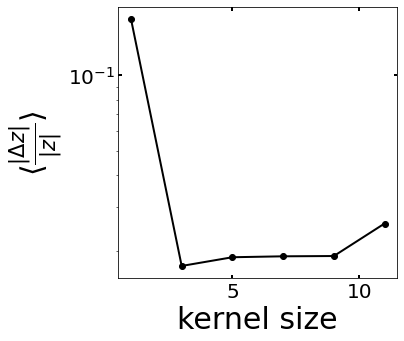

In [ ]:

dz=(np.average(np.abs(gs_density-min_density),axis=-1))/np.average(np.abs(gs_density),axis=-1)

fig=plt.figure(figsize=(5,5))
plt.plot(ks,np.average(dz,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'kernel size',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta z|}{|z|} \rangle$',fontsize=30)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.semilogy()
plt.show()  

Energy

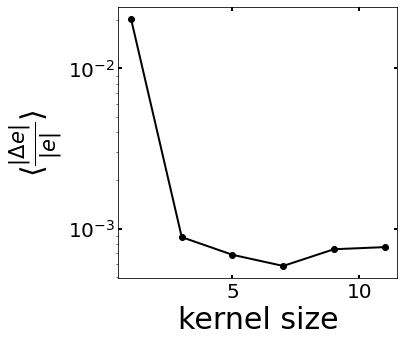

In [ ]:
de=np.abs(gs_energy-min_energy)/np.abs(gs_energy)

fig=plt.figure(figsize=(5,5))
plt.plot(ks,np.average(de,axis=-1),linestyle='-',marker='o',linewidth=2,color='black')
plt.xlabel(r'kernel size',fontsize=30)
plt.ylabel(r'$\langle \frac{|\Delta e|}{|e|} \rangle$',fontsize=30)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=2,
        )
plt.semilogy()
plt.show() 

#### Imports

In [3]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

## Scalability analysis at different Depth of the Neural Network

#### Imports

In [35]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

#### Data

In [36]:

models_name=[]
hc=''
for i in range(6):
    models_name.append('1nn_ising/h_2.7_15k_cnn_[40, 40'+hc+f']_hc_5_ks_1_ps_{i+2}_nconv_0_nblock')
    hc=hc+', 40'
        


blocks=[2,3,4,5,6,7]
ls=np.arange(16,65)
#ls=[16,24,32,48,64]

data_path=[f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{l}_l_2.7_h_200_n.npz' for l in ls]

#### Accuracy

In [37]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)  

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=441
R_square_test=0.999605655670166 for 1nn_ising/h_2.7_15k_cnn_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock 

de=0.002845682332348932 std(de)=0.0002330259589175811
Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=441
R_square_test=0.9996170401573181 for 1nn_ising/h_2.7_15k_cnn_[40, 40]_hc_

$R^2$

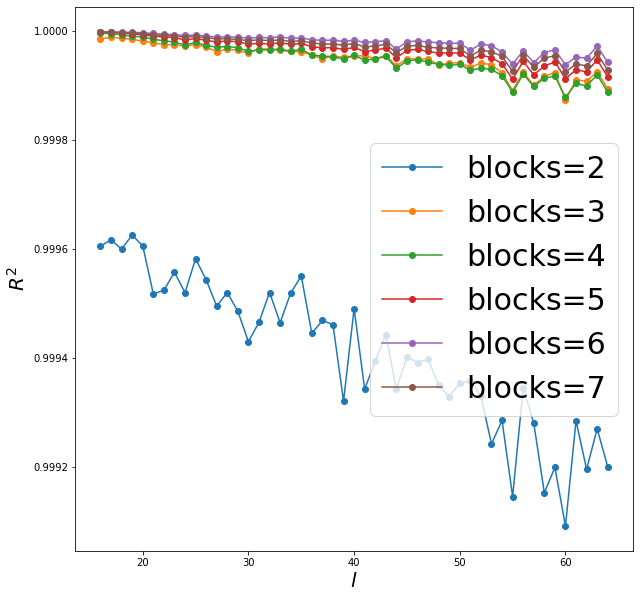

In [ ]:
plt.figure(figsize=(10,10))

for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'blocks={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

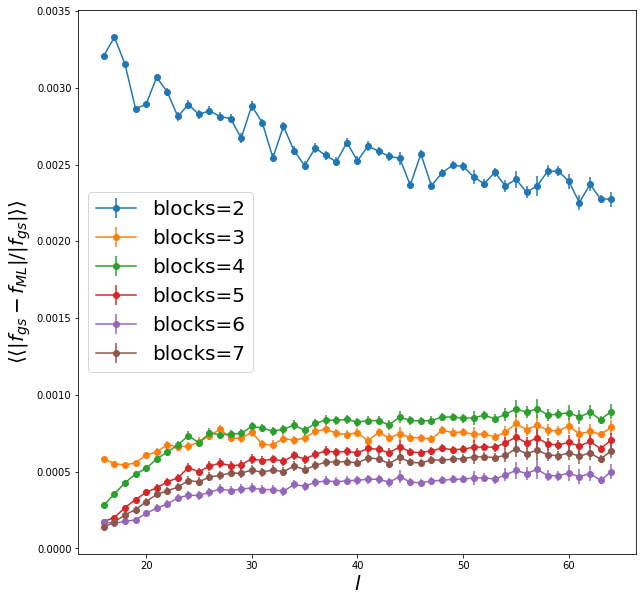

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'blocks={blocks[i]}')
plt.legend(fontsize=20)
#plt.plot(0.001*np.arange(len(ls))**(0.5))
#plt.loglog()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Descent Accuracy

In [ ]:
ndata=100
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

IndexError: list index out of range

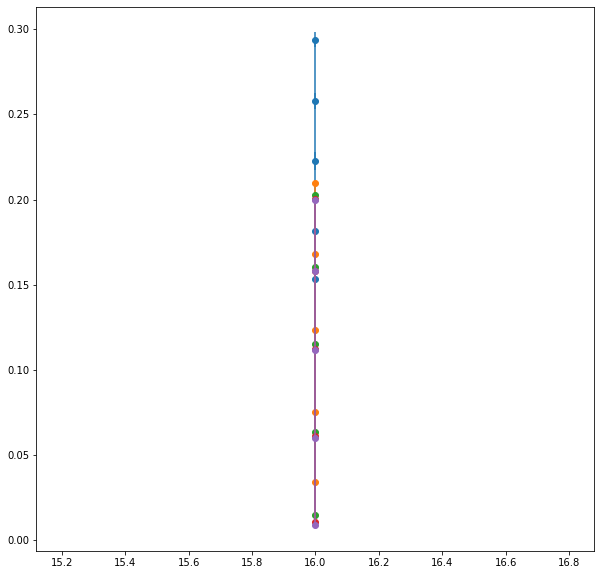

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'blocks={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.legend(fontsize=20)
plt.show()

## Prediction accuracy for different size training dataset

#### Imports

In [8]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

#### Data

In [31]:

models_name=[]
hc=''
l_train=['l_8_','l_12_','l_18_','l_24_']
for l in l_train:
    models_name.append(f'1nn_ising/h_2.7_150k_'+l+'cnn_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock')
        


blocks=[8,12,18,24]
ls=np.arange(8,65)
#ls=[16,24,32,48,64]

data_path=[f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{l}_l_2.7_h_200_n.npz' for l in ls]

#### Accuracy

In [32]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)  

Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=16521
R_square_test=0.9999989867210388 for 1nn_ising/h_2.7_150k_l_8_cnn_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock 

de=0.0001640765055693401 std(de)=1.3724172873464763e-05
Den2Func(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(

$R^2$

In [ ]:
plt.figure(figsize=(10,10))

for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'training l={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

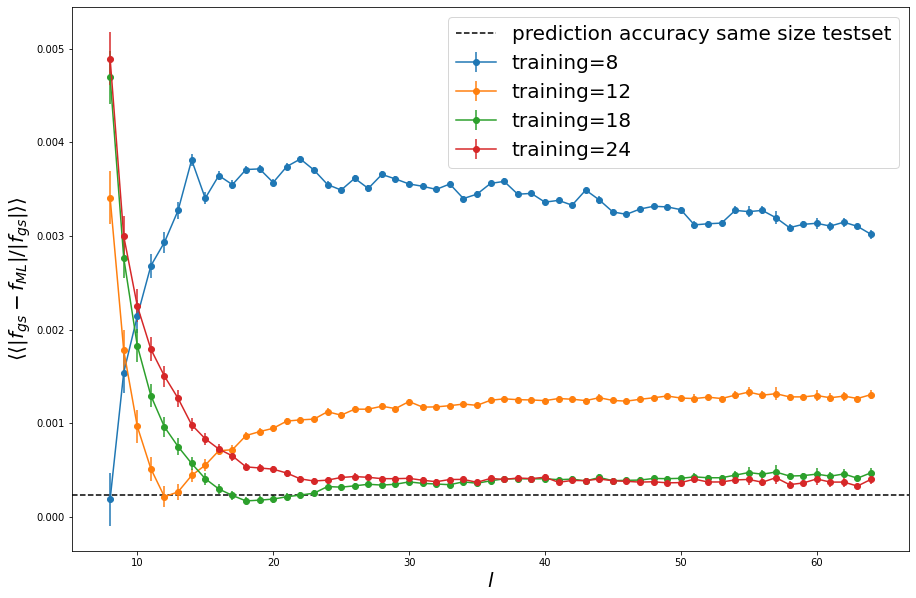

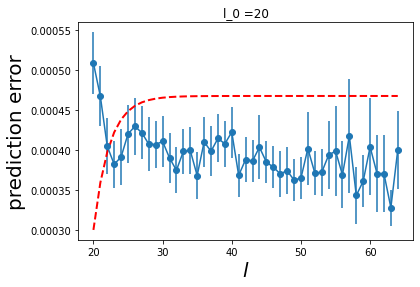

In [33]:
plt.figure(figsize=(15,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'training={blocks[i]}')

#plt.plot(0.001*np.arange(len(ls))**(0.5))
#plt.loglog()
plt.axhline(y=0.00023,color='black',linestyle='--',label='prediction accuracy same size testset')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|f_{gs}-f_{ML}|/|f_{gs}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()



l_0=20
chi=2.3
size=64
err_ml=3*10**-4
# simulator
x=np.arange(65)
err_l=np.exp(-1*l_0/chi)*(1-np.exp(-1*np.abs(x-l_0)/chi))
plt.errorbar(ls[12:],des[-1][12:],yerr=devde[12:],marker='o',label=f'ks=')
plt.plot(ls[12:],err_l[l_0:]+err_ml,color='red',linestyle='--',linewidth=2)
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel('prediction error',fontsize=20)
plt.title('l_0 =20')

plt.show()

#### Gradient Descent Accuracy

In [27]:
ndata=100
g_accs=[]
dev_g=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    dev_g.append([np.std(g)/np.sqrt(g.shape[0]) for g in g_acc])
    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

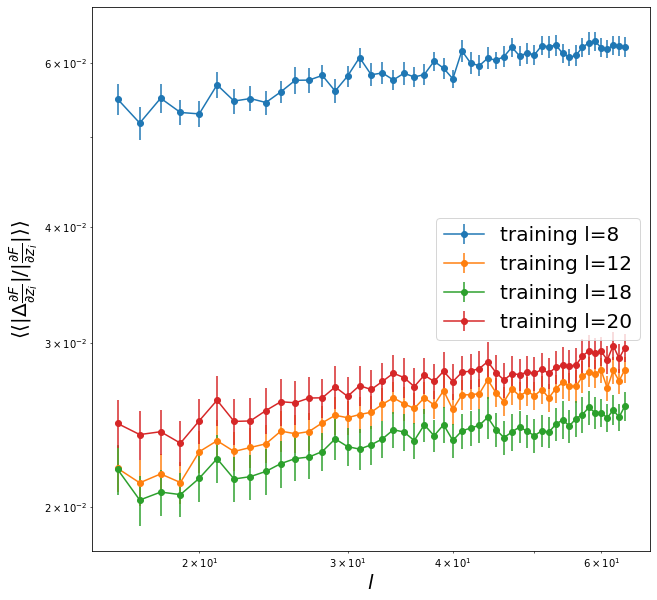

In [48]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,g_accs[i],yerr=dev_g[i],marker='o',label=f'training l={blocks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.legend(fontsize=20)
plt.show()

In [55]:
data=np.load('data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_128_l_5.44_h_100_n.npz')

v=data['potential']
j1=-1*np.ones((v.shape[0]))
j2=-1*np.ones((v.shape[0]))
print(j1.shape)
e=data['energy']


np.savetxt('field_realization.dat', v)
np.savetxt('energies.dat',e)



(100,)
